# Phase 1: RNA-Protein Binding Prediction - Data Exploration

## Overview
This notebook implements Phase 1 of the RNA-Protein Binding Prediction project using Basic Bidirectional LSTM to test model performance on biological sequence data.

**Objective**: Develop a deep learning model to predict RNA-binding protein (RBP) binding intensity to RNA sequences.

**Phase 1 Goals**:
- Explore and understand the training data structure
- Implement data preprocessing for RNA and protein sequences
- Create a basic bidirectional LSTM model
- Train and evaluate the model on a subset of data
- Establish baseline performance metrics

**Data**:
- Training: ~200 protein sequences with ~120K RNA sequences each
- Test: 44 protein sequences for final predictions
- Metric: Pearson correlation between predictions and actual binding scores

## 1. Import Required Libraries

In [3]:
# Core libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import signal
import json
from collections import Counter
from datetime import datetime

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

# For evaluation metrics
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For progress bars
from tqdm import tqdm


def create_run_directory(base_dir: str = "runs", run_name: str = None) -> str:
    if run_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_name = f"phase1_run_{timestamp}"
    
    run_dir = os.path.join(base_dir, run_name)
    os.makedirs(run_dir, exist_ok=True)
    
    # Create subdirectories including configs
    subdirs = ['models', 'plots', 'logs', 'metrics', 'configs']
    for subdir in subdirs:
        os.makedirs(os.path.join(run_dir, subdir), exist_ok=True)
    
    return run_dir

def save_training_config(config: dict, output_dir: str):
    """Save training configuration to a file."""
    config_path = os.path.join(output_dir, 'config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"Configuration saved to: {config_path}")

def save_training_summary(summary: dict, output_dir: str):
    """Save training summary to a file."""
    # Convert any numpy types to Python types for JSON serialization
    def convert_numpy(obj):
        if hasattr(obj, 'item'):
            return obj.item()
        elif hasattr(obj, 'tolist'):
            return obj.tolist()
        return obj
    
    json_summary = {}
    for key, value in summary.items():
        json_summary[key] = convert_numpy(value)
    
    summary_path = os.path.join(output_dir, 'training_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(json_summary, f, indent=2)
    
    print(f"Training summary saved to: {summary_path}")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Create run directory for this notebook session
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"notebook_phase1_{timestamp}"
run_dir = create_run_directory("../runs", run_name)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"📁 Run directory: {run_dir}")
print(f"🎯 Note: You can interrupt training with Ctrl+C (Kernel > Interrupt)")

Libraries imported successfully!
PyTorch version: 2.0.0+cu118
CUDA available: True
Device: cuda
📁 Run directory: ../runs\notebook_phase1_20250809_161254
🎯 Note: You can interrupt training with Ctrl+C (Kernel > Interrupt)


## 2. Data Loading and Exploration

Let's start by loading and exploring the structure of our RNA-protein binding dataset.

In [4]:
# Define data directory
data_dir = "../data"

# Load RNA sequences
print("Loading RNA sequences...")
rna_file = os.path.join(data_dir, 'training_seqs.txt')
with open(rna_file, 'r') as f:
    rna_sequences = [line.strip() for line in f.readlines()]

print(f"Loaded {len(rna_sequences):,} RNA sequences")
print(f"First 5 RNA sequences:")
for i, seq in enumerate(rna_sequences[:5]):
    print(f"  {i+1}: {seq}")

print("\n" + "="*60)

# Load protein sequences  
print("Loading protein sequences...")
protein_file = os.path.join(data_dir, 'training_RBPs2.txt')
with open(protein_file, 'r') as f:
    protein_sequences = [line.strip() for line in f.readlines()]

print(f"Loaded {len(protein_sequences):,} protein sequences")
print(f"First 3 protein sequences:")
for i, seq in enumerate(protein_sequences[:3]):
    print(f"  {i+1}: {seq[:60]}{'...' if len(seq) > 60 else ''} (length: {len(seq)})")

print("\n" + "="*60)

# Load a sample of binding scores to understand the format
print("Examining binding scores format...")
scores_file = os.path.join(data_dir, 'training_data2.txt')

# Read first few lines to understand structure
with open(scores_file, 'r') as f:
    sample_lines = [f.readline().strip() for _ in range(5)]

print("Sample binding score lines:")
for i, line in enumerate(sample_lines):
    scores = line.split()
    print(f"  Line {i+1}: {len(scores)} scores, first 10: {scores[:10]}")

print(f"\nData structure:")
print(f"- Each line represents binding scores for one RNA sequence across all {len(protein_sequences)} proteins")
print(f"- Total expected lines: {len(rna_sequences):,}")
print(f"- Each line should have {len(protein_sequences)} scores")

Loading RNA sequences...
Loaded 120,678 RNA sequences
First 5 RNA sequences:
  1: AGAAAAAAAAAGUCCGGAUAGUGGUGAGGUACUCUCAA
  2: AGAAAAAAAAUGGUAGCCAUUUGUAUCCGGUUUUGCUU
  3: AGAAAAAAACAAGAAAGGCUGGGCGAUCCUGUUCGACG
  4: AGAAAAAAACAAGAAUUUUCCUGGUGCAUUGGUCG
  5: AGAAAAAAACCAAACUCAUACUCAUCCGGAGUCCAAUA

Loading protein sequences...
Loaded 200 protein sequences
First 3 protein sequences:
  1: AAAAGKQIEGPEGCNLFIYHLPQEFTDTDLASTFLPFGNVISAKVFIDKQTSLSKCFGFV... (length: 98)
  2: AAFPNVFTHVERLLDEEIARVRASLFQINGVKKEPLTLPEPEGSVVTMNEKVYVPVREHP... (length: 194)
  3: AANSRQVAATAAAAAAVAAAAGGVGGAPQPGRSRLLEDFRNQRYPNLQLRDLANHIVEFS... (length: 391)

Examining binding scores format...
Sample binding score lines:
  Line 1: 200 scores, first 10: ['1.427', '1.511', '1.842', '2.430', '1.831', '1.140', '1.312', '1.617', '1.510', '1.902']
  Line 2: 200 scores, first 10: ['1.197', '1.909', '2.144', '2.504', '1.415', '1.124', '1.522', '1.731', '1.473', '1.534']
  Line 3: 200 scores, first 10: ['1.176', '1.478', '1.977', '2

Analyzing sequence characteristics...

RNA Sequence Statistics:
  Count: 120,678
  Length - Min: 30, Max: 41, Mean: 35.8
  Length - Median: 38.0, Std: 2.8
  Nucleotide composition: {'A': 1204909, 'C': 1026625, 'G': 1126804, 'U': 959296}

Protein Sequence Statistics:
  Count: 200
  Length - Min: 75, Max: 912, Mean: 298.0
  Length - Median: 273.0, Std: 137.3
  Top 10 amino acids: [('G', 5115), ('A', 4748), ('S', 4101), ('L', 4044), ('V', 3893), ('R', 3761), ('E', 3705), ('K', 3672), ('P', 3574), ('Q', 3085)]


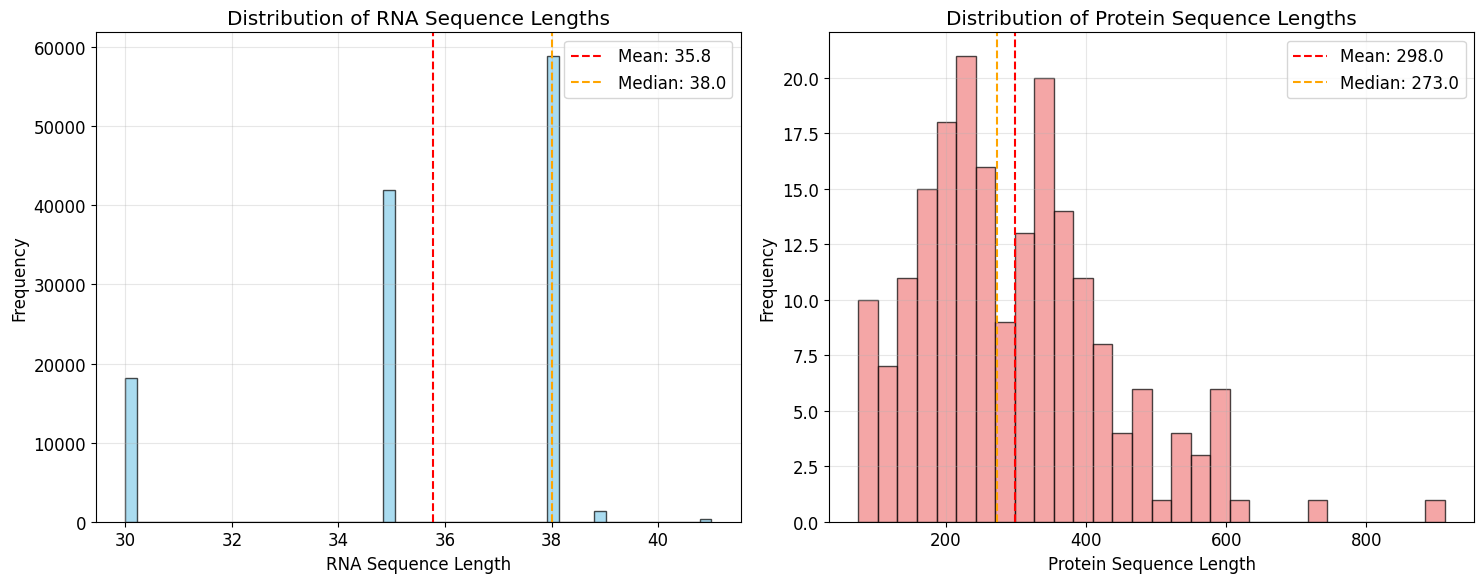


Recommended max lengths (95th percentile):
  RNA: 38
  Protein: 559


In [5]:
# Analyze sequence characteristics
print("Analyzing sequence characteristics...")

# RNA sequence analysis
rna_lengths = [len(seq) for seq in rna_sequences]
rna_nucleotide_counts = Counter(''.join(rna_sequences))

# Protein sequence analysis
protein_lengths = [len(seq) for seq in protein_sequences]
protein_aa_counts = Counter(''.join(protein_sequences))

# Display statistics
print("\nRNA Sequence Statistics:")
print(f"  Count: {len(rna_sequences):,}")
print(f"  Length - Min: {min(rna_lengths)}, Max: {max(rna_lengths)}, Mean: {np.mean(rna_lengths):.1f}")
print(f"  Length - Median: {np.median(rna_lengths):.1f}, Std: {np.std(rna_lengths):.1f}")
print(f"  Nucleotide composition: {dict(sorted(rna_nucleotide_counts.items()))}")

print("\nProtein Sequence Statistics:")
print(f"  Count: {len(protein_sequences):,}")
print(f"  Length - Min: {min(protein_lengths)}, Max: {max(protein_lengths)}, Mean: {np.mean(protein_lengths):.1f}")
print(f"  Length - Median: {np.median(protein_lengths):.1f}, Std: {np.std(protein_lengths):.1f}")

# Top 10 amino acids
top_aa = sorted(protein_aa_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"  Top 10 amino acids: {top_aa}")

# Visualize sequence length distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RNA length distribution
axes[0].hist(rna_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(np.mean(rna_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(rna_lengths):.1f}')
axes[0].axvline(np.median(rna_lengths), color='orange', linestyle='--', label=f'Median: {np.median(rna_lengths):.1f}')
axes[0].set_xlabel('RNA Sequence Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of RNA Sequence Lengths')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Protein length distribution
axes[1].hist(protein_lengths, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].axvline(np.mean(protein_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(protein_lengths):.1f}')
axes[1].axvline(np.median(protein_lengths), color='orange', linestyle='--', label=f'Median: {np.median(protein_lengths):.1f}')
axes[1].set_xlabel('Protein Sequence Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Protein Sequence Lengths')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal sequence lengths (95th percentile)
rna_95th = np.percentile(rna_lengths, 95)
protein_95th = np.percentile(protein_lengths, 95)

print(f"\nRecommended max lengths (95th percentile):")
print(f"  RNA: {rna_95th:.0f}")
print(f"  Protein: {protein_95th:.0f}")

Loading and analyzing binding scores...
Binding Score Statistics (sample of 200,000 scores):
  Min: 0.398
  Max: 5.879
  Mean: 1.785
  Median: 1.741
  Std: 0.432
  25th percentile: 1.492
  75th percentile: 2.028


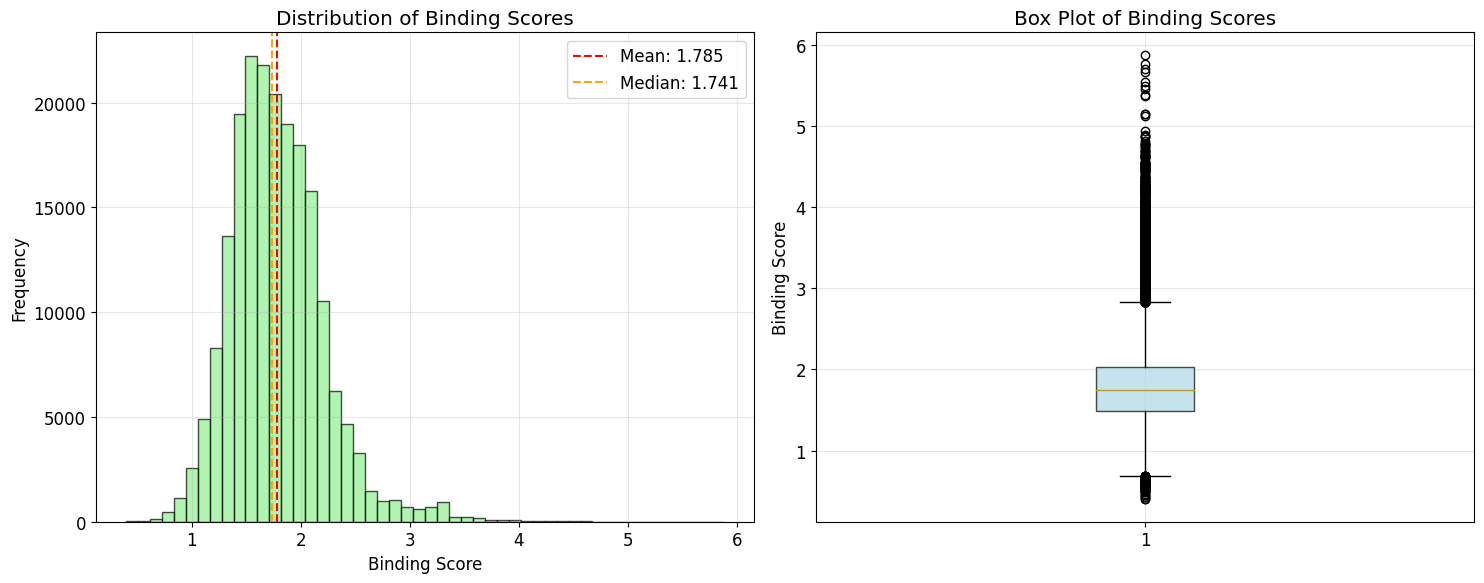


Data Quality Check:
  NaN values: 0
  Infinite values: 0
  Negative values: 0
  Values > 10: 0

Normalized scores (0-1 range):
  Min: 0.000, Max: 1.000
  Mean: 0.253, Std: 0.079


In [6]:
# Load and analyze binding scores (sample only due to large file size)
print("Loading and analyzing binding scores...")

# Load first 1000 lines of binding scores for analysis
sample_scores = []
with open(scores_file, 'r') as f:
    for i in range(1000):  # Sample first 1000 RNA sequences
        line = f.readline().strip()
        if line:
            scores = [float(x) for x in line.split()]
            sample_scores.extend(scores)

sample_scores = np.array(sample_scores)

print(f"Binding Score Statistics (sample of {len(sample_scores):,} scores):")
print(f"  Min: {sample_scores.min():.3f}")
print(f"  Max: {sample_scores.max():.3f}")
print(f"  Mean: {sample_scores.mean():.3f}")
print(f"  Median: {np.median(sample_scores):.3f}")
print(f"  Std: {sample_scores.std():.3f}")
print(f"  25th percentile: {np.percentile(sample_scores, 25):.3f}")
print(f"  75th percentile: {np.percentile(sample_scores, 75):.3f}")

# Visualize binding score distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
axes[0].hist(sample_scores, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0].axvline(sample_scores.mean(), color='red', linestyle='--', label=f'Mean: {sample_scores.mean():.3f}')
axes[0].axvline(np.median(sample_scores), color='orange', linestyle='--', label=f'Median: {np.median(sample_scores):.3f}')
axes[0].set_xlabel('Binding Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Binding Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(sample_scores, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Binding Score')
axes[1].set_title('Box Plot of Binding Scores')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for data quality issues
print(f"\nData Quality Check:")
print(f"  NaN values: {np.isnan(sample_scores).sum()}")
print(f"  Infinite values: {np.isinf(sample_scores).sum()}")
print(f"  Negative values: {(sample_scores < 0).sum()}")
print(f"  Values > 10: {(sample_scores > 10).sum()}")

# Normalize sample scores to see normalized distribution
normalized_scores = (sample_scores - sample_scores.min()) / (sample_scores.max() - sample_scores.min())
print(f"\nNormalized scores (0-1 range):")
print(f"  Min: {normalized_scores.min():.3f}, Max: {normalized_scores.max():.3f}")
print(f"  Mean: {normalized_scores.mean():.3f}, Std: {normalized_scores.std():.3f}")

## 3. Data Preprocessing and One-Hot Encoding

Now let's implement preprocessing functions for converting sequences to numerical representations.

Testing encoding functions...
Original RNA: AGAAAAAAAAAGUCCGGAUAGUGGUGAGGUACUCUCAA
Encoded shape: (50, 5)
First 5 positions (one-hot):
  Position 0: [1. 0. 0. 0. 0.] -> A
  Position 1: [0. 0. 1. 0. 0.] -> G
  Position 2: [1. 0. 0. 0. 0.] -> A
  Position 3: [1. 0. 0. 0. 0.] -> A
  Position 4: [1. 0. 0. 0. 0.] -> A

--------------------------------------------------
Original protein: AAAAGKQIEGPEGCNLFIYHLPQEFTDTDLASTFLPFGNVISAKVFIDKQ...
Encoded shape: (100, 21)
First 5 positions (one-hot):
  Position 0: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> A
  Position 1: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> A
  Position 2: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> A
  Position 3: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> A
  Position 4: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> G


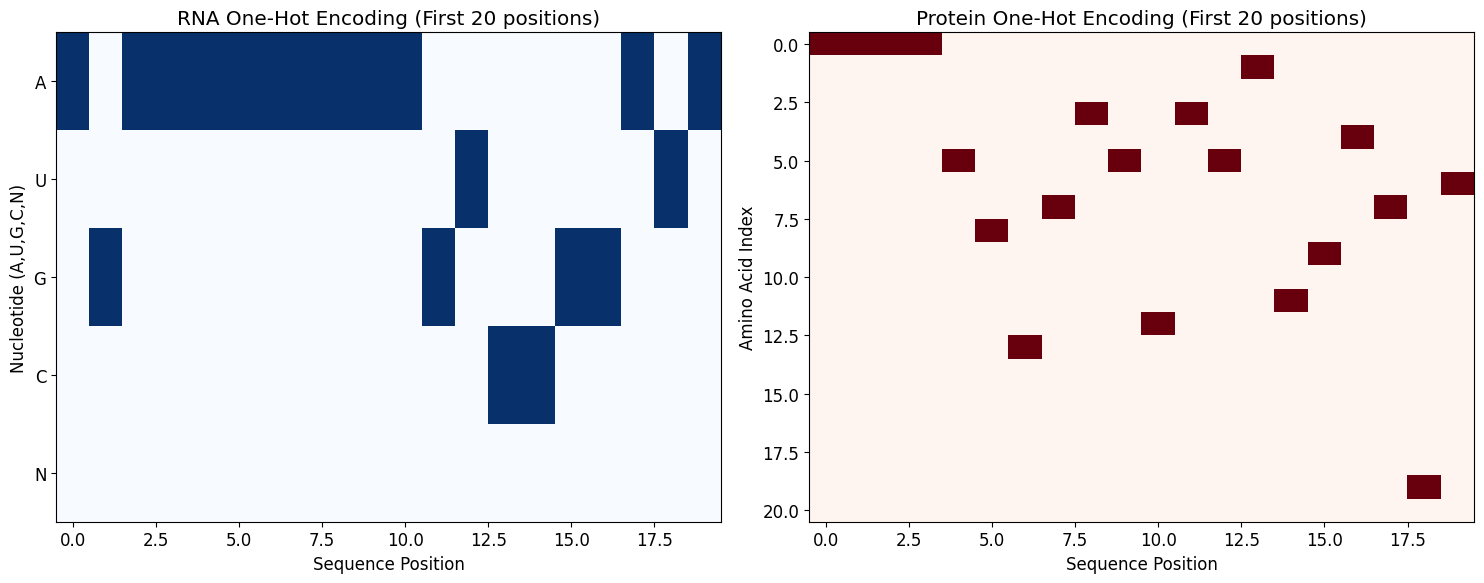

In [7]:
def encode_rna_sequence(sequence, max_length=None):
    """One-hot encode RNA sequence."""
    # RNA nucleotides mapping (A, U, G, C, N)
    nucleotide_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3, 'T': 1, 'N': 4}
    
    # Convert sequence to indices
    sequence_indices = []
    for nucleotide in sequence.upper():
        if nucleotide in nucleotide_mapping:
            sequence_indices.append(nucleotide_mapping[nucleotide])
        else:
            sequence_indices.append(nucleotide_mapping['N'])  # Unknown -> N
    
    # Pad or truncate to max_length if specified
    if max_length:
        if len(sequence_indices) > max_length:
            sequence_indices = sequence_indices[:max_length]
        else:
            sequence_indices.extend([4] * (max_length - len(sequence_indices)))  # Pad with 'N'
    
    # One-hot encode
    num_nucleotides = 5  # A, U, G, C, N
    one_hot = np.zeros((len(sequence_indices), num_nucleotides))
    for i, idx in enumerate(sequence_indices):
        one_hot[i, idx] = 1
    
    return one_hot

def encode_protein_sequence(sequence, max_length=None):
    """One-hot encode protein sequence."""
    # Standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_mapping = {aa: i for i, aa in enumerate(amino_acids)}
    aa_mapping['X'] = 20  # Unknown amino acid
    
    # Convert sequence to indices
    sequence_indices = []
    for aa in sequence.upper():
        if aa in aa_mapping:
            sequence_indices.append(aa_mapping[aa])
        else:
            sequence_indices.append(aa_mapping['X'])  # Unknown -> X
    
    # Pad or truncate to max_length if specified
    if max_length:
        if len(sequence_indices) > max_length:
            sequence_indices = sequence_indices[:max_length]
        else:
            sequence_indices.extend([20] * (max_length - len(sequence_indices)))  # Pad with 'X'
    
    # One-hot encode
    num_amino_acids = 21  # 20 standard + unknown
    one_hot = np.zeros((len(sequence_indices), num_amino_acids))
    for i, idx in enumerate(sequence_indices):
        one_hot[i, idx] = 1
    
    return one_hot

# Test encoding functions
print("Testing encoding functions...")

# Test RNA encoding
test_rna = rna_sequences[0]
encoded_rna = encode_rna_sequence(test_rna, max_length=50)
print(f"Original RNA: {test_rna}")
print(f"Encoded shape: {encoded_rna.shape}")
print(f"First 5 positions (one-hot):")
for i in range(5):
    print(f"  Position {i}: {encoded_rna[i]} -> {test_rna[i] if i < len(test_rna) else 'PAD'}")

print("\n" + "-"*50)

# Test protein encoding
test_protein = protein_sequences[0]
encoded_protein = encode_protein_sequence(test_protein, max_length=100)
print(f"Original protein: {test_protein[:50]}...")
print(f"Encoded shape: {encoded_protein.shape}")
print(f"First 5 positions (one-hot):")
for i in range(5):
    print(f"  Position {i}: {encoded_protein[i]} -> {test_protein[i] if i < len(test_protein) else 'PAD'}")

# Visualize encoding example
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RNA encoding visualization
axes[0].imshow(encoded_rna[:20].T, cmap='Blues', aspect='auto')
axes[0].set_xlabel('Sequence Position')
axes[0].set_ylabel('Nucleotide (A,U,G,C,N)')
axes[0].set_title('RNA One-Hot Encoding (First 20 positions)')
axes[0].set_yticks(range(5))
axes[0].set_yticklabels(['A', 'U', 'G', 'C', 'N'])

# Protein encoding visualization
axes[1].imshow(encoded_protein[:20].T, cmap='Reds', aspect='auto')
axes[1].set_xlabel('Sequence Position')
axes[1].set_ylabel('Amino Acid Index')
axes[1].set_title('Protein One-Hot Encoding (First 20 positions)')

plt.tight_layout()
plt.show()

## 4. Dataset and DataLoader Implementation

Let's create a PyTorch Dataset class for efficient data loading and batching.

In [8]:
class RNAProteinDataset(Dataset):
    """Dataset for RNA-Protein binding prediction."""
    
    def __init__(self, rna_sequences, protein_sequences, binding_scores, 
                 rna_max_length=50, protein_max_length=500, normalize_scores=True):
        self.rna_sequences = rna_sequences
        self.protein_sequences = protein_sequences
        self.binding_scores = binding_scores.copy()
        self.rna_max_length = rna_max_length
        self.protein_max_length = protein_max_length
        
        # Normalize binding scores to [0, 1] range
        if normalize_scores:
            min_score = self.binding_scores.min()
            max_score = self.binding_scores.max()
            self.binding_scores = (self.binding_scores - min_score) / (max_score - min_score)
        
        # Pre-encode sequences for efficiency
        print("Pre-encoding sequences...")
        self.rna_encoded = []
        self.protein_encoded = []
        
        for i, (rna_seq, protein_seq) in enumerate(zip(rna_sequences, protein_sequences)):
            if i % 1000 == 0:
                print(f"Encoded {i}/{len(rna_sequences)} sequences")
            
            rna_enc = encode_rna_sequence(rna_seq, self.rna_max_length)
            protein_enc = encode_protein_sequence(protein_seq, self.protein_max_length)
            
            self.rna_encoded.append(rna_enc)
            self.protein_encoded.append(protein_enc)
        
        print(f"Encoding complete. Dataset size: {len(self.rna_encoded)}")
    
    def __len__(self):
        return len(self.rna_sequences)
    
    def __getitem__(self, idx):
        rna_tensor = torch.FloatTensor(self.rna_encoded[idx])
        protein_tensor = torch.FloatTensor(self.protein_encoded[idx])
        score_tensor = torch.FloatTensor([self.binding_scores[idx]])
        
        return {
            'rna': rna_tensor,
            'protein': protein_tensor,
            'score': score_tensor
        }

def load_subset_data(data_dir, subset_size=1000):
    """Load a subset of the data for initial testing."""
    print(f"Loading subset of {subset_size} RNA sequences...")
    
    # Load RNA sequences (already loaded)
    rna_subset = rna_sequences[:subset_size]
    
    # Load corresponding binding scores
    binding_scores = []
    with open(os.path.join(data_dir, 'training_data2.txt'), 'r') as f:
        for i in range(subset_size):
            line = f.readline().strip()
            if line:
                scores = [float(x) for x in line.split()]
                binding_scores.extend(scores)
    
    binding_scores = np.array(binding_scores)
    
    # Create RNA-protein pairs
    rna_protein_pairs = []
    protein_rna_pairs = []
    final_scores = []
    
    scores_per_rna = len(protein_sequences)
    
    for rna_idx, rna_seq in enumerate(rna_subset):
        start_idx = rna_idx * scores_per_rna
        end_idx = start_idx + scores_per_rna
        
        if end_idx <= len(binding_scores):
            rna_scores = binding_scores[start_idx:end_idx]
            
            for protein_idx, protein_seq in enumerate(protein_sequences):
                rna_protein_pairs.append(rna_seq)
                protein_rna_pairs.append(protein_seq)
                final_scores.append(rna_scores[protein_idx])
    
    print(f"Created {len(rna_protein_pairs)} RNA-protein pairs")
    return rna_protein_pairs, protein_rna_pairs, np.array(final_scores)

# Load subset data for testing
subset_rna, subset_protein, subset_scores = load_subset_data(data_dir, subset_size=500)

print(f"Subset data summary:")
print(f"  RNA-protein pairs: {len(subset_rna)}")
print(f"  Score range: {subset_scores.min():.3f} - {subset_scores.max():.3f}")
print(f"  Score mean: {subset_scores.mean():.3f}")

# Set sequence lengths based on our analysis
RNA_MAX_LENGTH = 50  # All RNA sequences are this length
PROTEIN_MAX_LENGTH = 500  # Covers most proteins

# Create dataset
dataset = RNAProteinDataset(
    subset_rna, subset_protein, subset_scores,
    rna_max_length=RNA_MAX_LENGTH,
    protein_max_length=PROTEIN_MAX_LENGTH
)

# Split into train/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Dataset split:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Data loaders created with batch size: {batch_size}")

# Test data loader
sample_batch = next(iter(train_loader))
print(f"Sample batch shapes:")
print(f"  RNA: {sample_batch['rna'].shape}")
print(f"  Protein: {sample_batch['protein'].shape}")
print(f"  Scores: {sample_batch['score'].shape}")

Loading subset of 500 RNA sequences...
Created 100000 RNA-protein pairs
Subset data summary:
  RNA-protein pairs: 100000
  Score range: 0.427 - 5.668
  Score mean: 1.785
Pre-encoding sequences...
Encoded 0/100000 sequences
Encoded 1000/100000 sequences
Encoded 2000/100000 sequences
Encoded 3000/100000 sequences
Encoded 4000/100000 sequences
Encoded 5000/100000 sequences
Encoded 6000/100000 sequences
Encoded 7000/100000 sequences
Encoded 8000/100000 sequences
Encoded 9000/100000 sequences
Encoded 10000/100000 sequences
Encoded 11000/100000 sequences
Encoded 12000/100000 sequences
Encoded 13000/100000 sequences
Encoded 14000/100000 sequences
Encoded 15000/100000 sequences
Encoded 16000/100000 sequences
Encoded 17000/100000 sequences
Encoded 18000/100000 sequences
Encoded 19000/100000 sequences
Encoded 20000/100000 sequences
Encoded 21000/100000 sequences
Encoded 22000/100000 sequences
Encoded 23000/100000 sequences
Encoded 24000/100000 sequences
Encoded 25000/100000 sequences
Encoded 260

## 5. Basic Bidirectional LSTM Model

Now let's implement our bidirectional LSTM architecture for RNA-protein binding prediction.

In [9]:
class BasicLSTM(nn.Module):
    """Basic bidirectional LSTM for RNA-protein binding prediction."""
    
    def __init__(self,
                 rna_input_size=5,      # RNA nucleotides (A, U, G, C, N)
                 protein_input_size=21,  # Amino acids (20 + unknown)
                 rna_hidden_size=128,
                 protein_hidden_size=128,
                 num_layers=2,
                 dropout=0.2,
                 fusion_hidden_size=256):
        super(BasicLSTM, self).__init__()
        
        self.rna_hidden_size = rna_hidden_size
        self.protein_hidden_size = protein_hidden_size
        self.num_layers = num_layers
        
        # RNA sequence processing
        self.rna_lstm = nn.LSTM(
            input_size=rna_input_size,
            hidden_size=rna_hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        
        # Protein sequence processing  
        self.protein_lstm = nn.LSTM(
            input_size=protein_input_size,
            hidden_size=protein_hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        
        # Dropout layers
        self.dropout = nn.Dropout(dropout)
        
        # Fusion layers (*2 because of bidirectional LSTM)
        fusion_input_size = rna_hidden_size * 2 + protein_hidden_size * 2
        
        self.fusion_layers = nn.Sequential(
            nn.Linear(fusion_input_size, fusion_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_hidden_size, fusion_hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_hidden_size // 2, 1)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights."""
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                if 'bias_ih' in name:
                    n = param.size(0)
                    param.data[n//4:n//2].fill_(1)  # Set forget gate bias to 1
    
    def forward(self, rna, protein):
        batch_size = rna.size(0)
        
        # Process RNA sequences
        rna_output, (rna_hidden, _) = self.rna_lstm(rna)
        # Take the last hidden state from both directions
        rna_hidden = rna_hidden.view(self.num_layers, 2, batch_size, self.rna_hidden_size)
        rna_representation = torch.cat([rna_hidden[-1, 0], rna_hidden[-1, 1]], dim=1)
        
        # Process protein sequences
        protein_output, (protein_hidden, _) = self.protein_lstm(protein)
        # Take the last hidden state from both directions
        protein_hidden = protein_hidden.view(self.num_layers, 2, batch_size, self.protein_hidden_size)
        protein_representation = torch.cat([protein_hidden[-1, 0], protein_hidden[-1, 1]], dim=1)
        
        # Apply dropout
        rna_representation = self.dropout(rna_representation)
        protein_representation = self.dropout(protein_representation)
        
        # Combine representations
        combined = torch.cat([rna_representation, protein_representation], dim=1)
        
        # Predict binding score
        binding_score = self.fusion_layers(combined)
        
        return binding_score

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BasicLSTM(
    rna_input_size=5,
    protein_input_size=21,
    rna_hidden_size=128,
    protein_hidden_size=128,
    num_layers=2,
    dropout=0.2,
    fusion_hidden_size=256
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024**2:.1f} MB (FP32)")

# Test forward pass
model.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    rna_test = sample_batch['rna'].to(device)
    protein_test = sample_batch['protein'].to(device)
    
    output = model(rna_test, protein_test)
    print(f"\nForward pass test:")
    print(f"  Input RNA shape: {rna_test.shape}")
    print(f"  Input protein shape: {protein_test.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Sample predictions: {output[:5].flatten().cpu().numpy()}")

Using device: cuda
Model created:
  Total parameters: 1,247,745
  Trainable parameters: 1,247,745
  Model size: ~4.8 MB (FP32)

Forward pass test:
  Input RNA shape: torch.Size([32, 50, 5])
  Input protein shape: torch.Size([32, 500, 21])
  Output shape: torch.Size([32, 1])
  Sample predictions: [0.00168179 0.00054689 0.00079086 0.00079611 0.00156629]


## 6. Training Loop Implementation

Let's implement the training loop with proper loss calculation and optimization.

In [10]:
# Enhanced Training setup with early stopping and overfitting prevention
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training configuration
training_config = {
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'patience': 10,
    'min_delta': 1e-4,
    'max_grad_norm': 1.0,
    'lr_scheduler_patience': 5,
    'lr_scheduler_factor': 0.5,
    'num_epochs': 15,
    'device': str(device),
    'run_name': run_name,
    'timestamp': datetime.now().isoformat()
}

# Save configuration
save_training_config(training_config, run_dir)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=training_config['learning_rate'], 
                      weight_decay=training_config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=training_config['lr_scheduler_factor'], 
    patience=training_config['lr_scheduler_patience'], verbose=True
)

def calculate_pearson_correlation(y_true, y_pred):
    """Calculate Pearson correlation coefficient."""
    correlation, _ = pearsonr(y_true.flatten(), y_pred.flatten())
    return correlation if not np.isnan(correlation) else 0.0

# Interruption handling for notebook
class TrainingInterruptHandler:
    def __init__(self):
        self.interrupted = False
        
    def interrupt(self):
        self.interrupted = True
        print("\n🛑 Training interrupted! Finishing current epoch...")

# Create interrupt handler
interrupt_handler = TrainingInterruptHandler()

def train_epoch_enhanced(model, train_loader, criterion, optimizer, device, interrupt_handler, max_grad_norm=1.0):
    """Enhanced training epoch with interruption handling and gradient clipping."""
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, batch in enumerate(progress_bar):
        if interrupt_handler.interrupted:
            print(f"Training interrupted at batch {batch_idx}")
            break
            
        # Move data to device
        rna = batch['rna'].to(device)
        protein = batch['protein'].to(device)
        targets = batch['score'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(rna, protein)
        
        # Calculate loss
        loss = criterion(predictions, targets)
        
        # Backward pass
        loss.backward()
        
        # Enhanced gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        
        # Update weights
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        all_predictions.append(predictions.detach().cpu().numpy())
        all_targets.append(targets.detach().cpu().numpy())
        
        # Update progress bar with gradient info
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float('inf'))
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Grad Norm': f'{grad_norm:.3f}'
        })
    
    # Calculate epoch metrics
    if all_predictions:
        predictions = np.concatenate(all_predictions, axis=0)
        targets = np.concatenate(all_targets, axis=0)
        correlation = calculate_pearson_correlation(targets, predictions)
    else:
        correlation = 0.0
    
    return total_loss / len(train_loader) if len(train_loader) > 0 else float('inf'), correlation

def validate_epoch_enhanced(model, val_loader, criterion, device):
    """Enhanced validation with better error handling."""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            # Move data to device
            rna = batch['rna'].to(device)
            protein = batch['protein'].to(device)
            targets = batch['score'].to(device)
            
            # Forward pass
            predictions = model(rna, protein)
            
            # Calculate loss
            loss = criterion(predictions, targets)
            
            # Track metrics
            total_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Calculate epoch metrics
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    correlation = calculate_pearson_correlation(targets, predictions)
    
    return total_loss / len(val_loader), correlation, predictions, targets

print("🎯 Enhanced training setup complete!")
print(f"📋 Configuration saved to: {os.path.join(run_dir, 'config.json')}")
print("⚠️  Note: Training can be interrupted safely - progress will be saved")
print("🛡️  Early stopping and overfitting detection enabled")

Configuration saved to: ../runs\notebook_phase1_20250809_161254\config.json
🎯 Enhanced training setup complete!
📋 Configuration saved to: ../runs\notebook_phase1_20250809_161254\config.json
⚠️  Note: Training can be interrupted safely - progress will be saved
🛡️  Early stopping and overfitting detection enabled


In [11]:
# Enhanced Training loop with interruption handling and overfitting prevention
num_epochs = training_config['num_epochs']
train_losses = []
val_losses = []
train_correlations = []
val_correlations = []
best_val_correlation = -np.inf
best_model_state = None
epochs_without_improvement = 0
patience = training_config['patience']
min_delta = training_config['min_delta']

print(f"🚀 Starting enhanced training for {num_epochs} epochs...")
print(f"💻 Device: {device}")
print(f"⏹️  Early stopping patience: {patience}")
print(f"📏 Min improvement delta: {min_delta}")
print(f"✂️  Gradient clipping: {training_config['max_grad_norm']}")
print("🛑 Press Ctrl+C (or Kernel > Interrupt) to stop training gracefully")
print("="*60)

start_time = time.time()

try:
    for epoch in range(num_epochs):
        if interrupt_handler.interrupted:
            print(f"🛑 Training stopped at epoch {epoch+1} due to interruption")
            break
            
        epoch_start = time.time()
        
        # Train with enhanced features
        train_loss, train_corr = train_epoch_enhanced(
            model, train_loader, criterion, optimizer, device, 
            interrupt_handler, training_config['max_grad_norm']
        )
        
        if interrupt_handler.interrupted:
            print(f"🛑 Epoch {epoch+1} interrupted during training")
            break
        
        # Validate
        val_loss, val_corr, val_predictions, val_targets = validate_epoch_enhanced(
            model, val_loader, criterion, device
        )
        
        # Update scheduler
        scheduler.step(val_corr)
        
        # Track metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_correlations.append(train_corr)
        val_correlations.append(val_corr)
        
        # Check for improvement
        improvement = val_corr - best_val_correlation
        if improvement > min_delta:
            epochs_without_improvement = 0
            best_val_correlation = val_corr
            best_model_state = model.state_dict().copy()
            print(f"💾 New best model! Correlation improved by {improvement:.4f}")
        else:
            epochs_without_improvement += 1
        
        epoch_time = time.time() - epoch_start
        lr = optimizer.param_groups[0]['lr']
        
        # Enhanced epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} ({epoch_time:.1f}s) - LR: {lr:.2e}")
        print(f"  📉 Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"  📊 Train Corr: {train_corr:.4f}, Val Corr: {val_corr:.4f}")
        print(f"  🏆 Best Val Corr: {best_val_correlation:.4f}")
        print(f"  ⏳ Epochs w/o improvement: {epochs_without_improvement}/{patience}")
        
        # Enhanced overfitting detection
        if len(train_correlations) > 5:
            recent_train = np.mean(train_correlations[-3:])
            recent_val = np.mean(val_correlations[-3:])
            overfitting_gap = recent_train - recent_val
            
            if overfitting_gap > 0.15:
                print(f"  ⚠️  Overfitting warning! Gap: {overfitting_gap:.3f}")
                if overfitting_gap > 0.25:
                    print(f"  🛑 Severe overfitting detected, stopping training")
                    break
        
        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs")
            break
        
        print()

except KeyboardInterrupt:
    print(f"\n🛑 Training interrupted by user at epoch {len(train_losses)+1}")
    interrupt_handler.interrupt()

total_time = time.time() - start_time

# Load best model if available
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model (correlation: {best_val_correlation:.4f})")

# Create and save training summary
training_summary = {
    'best_val_correlation': best_val_correlation,
    'best_epoch': np.argmax(val_correlations) if val_correlations else 0,
    'final_train_correlation': train_correlations[-1] if train_correlations else 0,
    'final_val_correlation': val_correlations[-1] if val_correlations else 0,
    'total_epochs': len(train_losses),
    'total_training_time': total_time,
    'interrupted': interrupt_handler.interrupted,
    'early_stopped': epochs_without_improvement >= patience,
    'training_config': training_config,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_correlations': train_correlations,
    'val_correlations': val_correlations
}

save_training_summary(training_summary, run_dir)

print(f"\n{'='*60}")
print(f"🏁 Training completed in {total_time:.1f}s")
if interrupt_handler.interrupted:
    print(f"🛑 Training was interrupted by user")
elif training_summary['early_stopped']:
    print(f"🛑 Training stopped early due to no improvement")
else:
    print(f"✅ Training completed all epochs")
print(f"📊 Best validation correlation: {best_val_correlation:.4f}")
print(f"📁 Results saved to: {run_dir}")
print("="*60)

🚀 Starting enhanced training for 15 epochs...
💻 Device: cuda
⏹️  Early stopping patience: 10
📏 Min improvement delta: 0.0001
✂️  Gradient clipping: 1.0
🛑 Press Ctrl+C (or Kernel > Interrupt) to stop training gracefully


Validating: 100%|██████████| 625/625 [00:20<00:00, 30.92it/s]


💾 New best model! Correlation improved by inf
Epoch 1/15 (203.0s) - LR: 1.00e-03
  📉 Train Loss: 0.0069, Val Loss: 0.0064
  📊 Train Corr: 0.1471, Val Corr: 0.2782
  🏆 Best Val Corr: 0.2782
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:17<00:00, 35.29it/s]


💾 New best model! Correlation improved by 0.0767
Epoch 2/15 (216.2s) - LR: 1.00e-03
  📉 Train Loss: 0.0064, Val Loss: 0.0059
  📊 Train Corr: 0.2483, Val Corr: 0.3549
  🏆 Best Val Corr: 0.3549
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:17<00:00, 34.77it/s]


💾 New best model! Correlation improved by 0.0495
Epoch 3/15 (206.7s) - LR: 1.00e-03
  📉 Train Loss: 0.0060, Val Loss: 0.0056
  📊 Train Corr: 0.3424, Val Corr: 0.4044
  🏆 Best Val Corr: 0.4044
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:20<00:00, 29.96it/s]


💾 New best model! Correlation improved by 0.0189
Epoch 4/15 (228.6s) - LR: 1.00e-03
  📉 Train Loss: 0.0059, Val Loss: 0.0055
  📊 Train Corr: 0.3720, Val Corr: 0.4233
  🏆 Best Val Corr: 0.4233
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:18<00:00, 33.56it/s]


💾 New best model! Correlation improved by 0.0055
Epoch 5/15 (212.1s) - LR: 1.00e-03
  📉 Train Loss: 0.0058, Val Loss: 0.0054
  📊 Train Corr: 0.3892, Val Corr: 0.4288
  🏆 Best Val Corr: 0.4288
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:21<00:00, 29.52it/s]


💾 New best model! Correlation improved by 0.0230
Epoch 6/15 (203.5s) - LR: 1.00e-03
  📉 Train Loss: 0.0057, Val Loss: 0.0054
  📊 Train Corr: 0.4039, Val Corr: 0.4518
  🏆 Best Val Corr: 0.4518
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:20<00:00, 30.20it/s]


💾 New best model! Correlation improved by 0.0015
Epoch 7/15 (243.6s) - LR: 1.00e-03
  📉 Train Loss: 0.0057, Val Loss: 0.0054
  📊 Train Corr: 0.4085, Val Corr: 0.4533
  🏆 Best Val Corr: 0.4533
  ⏳ Epochs w/o improvement: 0/10



Validating: 100%|██████████| 625/625 [00:19<00:00, 32.57it/s]


Epoch 8/15 (234.6s) - LR: 1.00e-03
  📉 Train Loss: 0.0056, Val Loss: 0.0053
  📊 Train Corr: 0.4134, Val Corr: 0.4500
  🏆 Best Val Corr: 0.4533
  ⏳ Epochs w/o improvement: 1/10



Validating: 100%|██████████| 625/625 [00:19<00:00, 31.70it/s]


💾 New best model! Correlation improved by 0.0058
Epoch 9/15 (224.5s) - LR: 1.00e-03
  📉 Train Loss: 0.0056, Val Loss: 0.0052
  📊 Train Corr: 0.4179, Val Corr: 0.4591
  🏆 Best Val Corr: 0.4591
  ⏳ Epochs w/o improvement: 0/10



Validating:  62%|██████▏   | 390/625 [00:12<00:07, 30.31it/s]


🛑 Training interrupted by user at epoch 10

🛑 Training interrupted! Finishing current epoch...
✅ Loaded best model (correlation: 0.4591)
Training summary saved to: ../runs\notebook_phase1_20250809_161254\training_summary.json

🏁 Training completed in 2197.5s
🛑 Training was interrupted by user
📊 Best validation correlation: 0.4591
📁 Results saved to: ../runs\notebook_phase1_20250809_161254


## 7. Model Evaluation and Metrics

Let's evaluate the trained model and calculate comprehensive metrics.

In [ ]:
# Evaluate on validation set with best model
model.eval()
val_loss, val_corr, final_predictions, final_targets = validate_epoch(model, val_loader, criterion, device)

# Calculate additional metrics
mse = mean_squared_error(final_targets.flatten(), final_predictions.flatten())
mae = mean_absolute_error(final_targets.flatten(), final_predictions.flatten())
rmse = np.sqrt(mse)

print("Final Model Performance:")
print(f"  Validation Loss (MSE): {val_loss:.4f}")
print(f"  Pearson Correlation: {val_corr:.4f}")
print(f"  Mean Absolute Error: {mae:.4f}")
print(f"  Root Mean Square Error: {rmse:.4f}")

# Model inference speed test
print("\nInference Speed Test:")
model.eval()
with torch.no_grad():
    # Get a batch for timing
    test_batch = next(iter(val_loader))
    rna_test = test_batch['rna'].to(device)
    protein_test = test_batch['protein'].to(device)
    
    # Warmup
    for _ in range(10):
        _ = model(rna_test, protein_test)
    
    # Time inference
    start_time = time.time()
    num_runs = 100
    for _ in range(num_runs):
        _ = model(rna_test, protein_test)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_runs
    samples_per_second = rna_test.size(0) / avg_time

print(f"  Average inference time: {avg_time*1000:.2f}ms per batch")
print(f"  Throughput: {samples_per_second:.1f} samples/second")

# Analyze predictions by protein type (first few proteins)
print(f"\nPrediction Analysis by Protein Type:")
proteins_per_rna = len(protein_sequences)
unique_proteins = list(set(subset_protein))[:5]  # First 5 unique proteins

for i, protein in enumerate(unique_proteins):
    # Find predictions for this protein
    protein_mask = np.array(subset_protein) == protein
    if np.any(protein_mask):
        protein_indices = np.where(protein_mask)[0]
        
        # Get corresponding predictions from validation set
        val_indices = []
        for idx in val_dataset.indices:
            if idx in protein_indices:
                val_indices.append(list(protein_indices).index(idx))
        
        if val_indices:
            protein_preds = final_predictions[val_indices]
            protein_targets = final_targets[val_indices]
            protein_corr = calculate_pearson_correlation(protein_targets, protein_preds)
            
            print(f"  Protein {i+1} (length {len(protein)}): correlation = {protein_corr:.4f}, "
                  f"samples = {len(protein_preds)}")

# Performance summary
print(f"\nPhase 1 Summary:")
print(f"  Model: Basic Bidirectional LSTM")
print(f"  Dataset: {len(subset_rna)} RNA-protein pairs")
print(f"  Training time: {total_time:.1f}s")
print(f"  Best validation correlation: {best_val_correlation:.4f}")
print(f"  Final validation correlation: {val_corr:.4f}")

# Recommendations
print(f"\nRecommendations for Phase 2:")
if best_val_correlation > 0.3:
    print("✓ Good performance! Ready to add self-attention mechanism")
elif best_val_correlation > 0.2:
    print("○ Moderate performance. Consider tuning hyperparameters or adding attention")
else:
    print("⚠ Low performance. Consider:")
    print("  - Increasing model size")
    print("  - Using more training data") 
    print("  - Adjusting learning rate")
    print("  - Adding regularization")

## 8. Results Visualization

Let's create comprehensive visualizations of our training results and model performance.

In [ ]:
# Create comprehensive visualization with organized output
plots_dir = os.path.join(run_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training/Validation Loss
axes[0, 0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0, 0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add annotations for early stopping
if training_summary['early_stopped']:
    best_epoch = training_summary['best_epoch']
    axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label='Best Model')
    axes[0, 0].legend()

# 2. Training/Validation Correlation
axes[0, 1].plot(train_correlations, label='Training Correlation', color='blue', linewidth=2)
axes[0, 1].plot(val_correlations, label='Validation Correlation', color='orange', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Pearson Correlation')
axes[0, 1].set_title('Training and Validation Correlation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Add overfitting detection visualization
if len(train_correlations) > 5:
    overfitting_gap = [tc - vc for tc, vc in zip(train_correlations, val_correlations)]
    axes[0, 1].fill_between(range(len(overfitting_gap)), 
                           [min(val_correlations)] * len(overfitting_gap),
                           [min(val_correlations) + gap for gap in overfitting_gap],
                           alpha=0.2, color='red', label='Overfitting Gap')

# 3. Predictions vs Targets Scatter Plot
if 'val_predictions' in locals() and 'val_targets' in locals():
    final_predictions = val_predictions
    final_targets = val_targets
else:
    # Re-evaluate if needed
    model.eval()
    with torch.no_grad():
        val_loss, val_corr, final_predictions, final_targets = validate_epoch_enhanced(
            model, val_loader, criterion, device
        )

axes[1, 0].scatter(final_targets.flatten(), final_predictions.flatten(), alpha=0.6, s=20)
min_val = min(final_targets.min(), final_predictions.min())
max_val = max(final_targets.max(), final_predictions.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
correlation = calculate_pearson_correlation(final_targets, final_predictions)
axes[1, 0].set_xlabel('True Binding Scores')
axes[1, 0].set_ylabel('Predicted Binding Scores')
axes[1, 0].set_title(f'Predictions vs Targets\nPearson Correlation: {correlation:.4f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Enhanced Residuals Plot with distribution
residuals = final_targets.flatten() - final_predictions.flatten()
axes[1, 1].scatter(final_predictions.flatten(), residuals, alpha=0.6, s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Binding Scores')
axes[1, 1].set_ylabel('Residuals (True - Predicted)')
axes[1, 1].set_title(f'Residuals Plot\nMean: {residuals.mean():.4f}, Std: {residuals.std():.4f}')
axes[1, 1].grid(True, alpha=0.3)

# Add residual statistics
residual_stats = f"RMSE: {np.sqrt(np.mean(residuals**2)):.4f}\nMAE: {np.mean(np.abs(residuals)):.4f}"
axes[1, 1].text(0.05, 0.95, residual_stats, transform=axes[1, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Phase 1 Training Results - {run_name}', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save main plot
main_plot_path = os.path.join(plots_dir, 'training_results.png')
plt.savefig(main_plot_path, dpi=300, bbox_inches='tight')
print(f"📊 Main results plot saved to: {main_plot_path}")
plt.show()

# Additional detailed plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Error distribution with statistics
axes[0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
axes[0].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.4f}')
axes[0].axvline(np.median(residuals), color='orange', linestyle='--', label=f'Median: {np.median(residuals):.4f}')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate evolution
if hasattr(scheduler, '_last_lr'):
    lr_history = [training_config['learning_rate']]  # Starting LR
    # Note: In practice, you'd track this during training
else:
    lr_history = [training_config['learning_rate']] * len(train_losses)

axes[1].plot(lr_history[:len(train_losses)], 'g-', linewidth=2, label='Learning Rate')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Model convergence analysis
if len(val_correlations) > 1:
    correlation_improvement = np.diff(val_correlations)
    axes[2].plot(correlation_improvement, 'purple', linewidth=2, label='Correlation Δ')
    axes[2].axhline(y=min_delta, color='red', linestyle='--', alpha=0.7, label=f'Min Delta: {min_delta}')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Validation Correlation Improvement')
    axes[2].set_title('Model Convergence Analysis')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()

# Save detailed plot
detailed_plot_path = os.path.join(plots_dir, 'detailed_analysis.png')
plt.savefig(detailed_plot_path, dpi=300, bbox_inches='tight')
print(f"📊 Detailed analysis plot saved to: {detailed_plot_path}")
plt.show()

# Model performance summary table
summary_data = {
    'Metric': ['Pearson Correlation', 'Mean Squared Error', 'Mean Absolute Error', 
               'Root Mean Square Error', 'Training Time (s)', 'Total Epochs',
               'Early Stopped', 'Interrupted'],
    'Value': [f'{correlation:.4f}', 
              f'{mean_squared_error(final_targets.flatten(), final_predictions.flatten()):.4f}',
              f'{mean_absolute_error(final_targets.flatten(), final_predictions.flatten()):.4f}',
              f'{np.sqrt(mean_squared_error(final_targets.flatten(), final_predictions.flatten())):.4f}',
              f'{total_time:.1f}', 
              f'{len(train_losses)}',
              f'{training_summary["early_stopped"]}',
              f'{training_summary["interrupted"]}']
}

summary_df = pd.DataFrame(summary_data)
print("\\n" + "="*50)
print("📊 PHASE 1 PERFORMANCE SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)

# Save model for future use
model_save_path = os.path.join(run_dir, 'models', 'phase1_basic_lstm_model.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'rna_input_size': 5,
        'protein_input_size': 21,
        'rna_hidden_size': 128,
        'protein_hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.2,
        'fusion_hidden_size': 256
    },
    'training_history': training_summary,
    'sequence_lengths': {
        'rna_max_length': RNA_MAX_LENGTH,
        'protein_max_length': PROTEIN_MAX_LENGTH
    },
    'final_performance': {
        'correlation': correlation,
        'mse': mean_squared_error(final_targets.flatten(), final_predictions.flatten()),
        'mae': mean_absolute_error(final_targets.flatten(), final_predictions.flatten())
    }
}, model_save_path)

print(f"\\n💾 Model saved to: {model_save_path}")
print(f"📁 All outputs saved to: {run_dir}")
print(f"📊 Plots directory: {plots_dir}")

print("\\n🎉 PHASE 1 COMPLETE!")
print("\\n🚀 Next Steps for Phase 2:")
print("1. ✅ Implement self-attention mechanism for RNA sequences")
print("2. 📊 Add attention visualization capabilities") 
print("3. 🔄 Compare performance with basic LSTM")
print("4. 🔗 Consider cross-attention between RNA and protein sequences")
print("5. 📈 Scale up to larger datasets")

# Performance recommendations
print(f"\\n📋 Recommendations based on correlation {correlation:.4f}:")
if correlation > 0.3:
    print("✅ Excellent! Ready for Phase 2 with attention mechanisms")
elif correlation > 0.2:
    print("🔶 Good baseline. Phase 2 should improve performance significantly")  
else:
    print("⚠️  Consider tuning hyperparameters before Phase 2:")
    print("   - Increase model size (hidden_size)")
    print("   - Use more training data")
    print("   - Adjust learning rate or add regularization")